In [25]:
import slax as sl
import flax.linen as nn
import jax.numpy as jnp
import jax
import optax
import pickle
from jax.tree_util import tree_map, Partial, tree_leaves, tree_structure, tree_unflatten
import matplotlib.pyplot as plt

In [26]:
input_sz = 50
output_sz = 10
seq_len = 50
manifold_key = jax.random.PRNGKey(0)
random_seed = manifold_key
key = manifold_key
batch_sz = 32

In [27]:
batch = sl.randman(manifold_key,random_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,batch_sz=batch_sz,dim_manifold=2,alpha=2.)

In [28]:
test_batch = sl.randman(manifold_key,random_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,dim_manifold=2,alpha=2.)

In [29]:
class snn(nn.Module):
    @nn.compact
    def __call__(self,carry,x):
        if carry[2] == None:
            carry[2] = {'1_0':jnp.zeros((x.shape[0],output_sz))}
        x = nn.Dense(100)(jnp.concatenate([x,carry[2]['1_0']],axis=-1))
        carry[0],x = sl.LIF(0.7)(carry[0],x)
        x = nn.Dense(10)(x)
        carry[1],x = sl.LIF(jnp.ones(output_sz)*0.2,spike_fn=sl.fast_sigmoid(),trainable_tau=True)(carry[1],x)
        carry[2]['1_0'] = x
        return carry,x

In [30]:
class OSTL_snn(nn.Module):
    @nn.compact
    def __call__(self,carry,x):
        if carry[2] == None:
            carry[2] = {'1_0':jnp.zeros((x.shape[0],output_sz))}
        carry[0], x = sl.DenseOSTL([nn.Dense(100),
                    sl.LIF(0.7)])(carry[0],jnp.concatenate([x,carry[2]['1_0']],axis=-1))
        carry[1], x = sl.DenseOSTL([nn.Dense(10),
                    sl.LIF(jnp.ones(output_sz)*0.2,spike_fn=sl.fast_sigmoid(),trainable_tau=True)])(carry[1],x)
        carry[2]['1_0'] = x
        return carry,x

In [31]:
bp_model = snn()
bp_params = bp_model.init(key,[None]*3,jnp.zeros_like(batch[0][0]))
bp_carry,_ = bp_model.apply(bp_params,[None]*3,jnp.zeros_like(batch[0][0]))
bp_test_carry,_ = bp_model.apply(bp_params,[None]*3,jnp.zeros_like(test_batch[0][0]))

In [8]:
ostl_model = OSTL_snn()
ostl_params = ostl_model.init(key,[None]*3,jnp.zeros_like(batch[0][0]))
ostl_carry,_ = ostl_model.apply(ostl_params,[None]*3,jnp.zeros_like(batch[0][0]))
ostl_params = tree_unflatten(tree_structure(ostl_params),tree_leaves(bp_params))

In [9]:
optimizer = optax.adam(0.01)
bp_opt_state = optimizer.init(bp_params)
ostl_opt_state = optimizer.init(ostl_params)

In [10]:
train_func = sl.train_offline(bp_model,optax.softmax_cross_entropy,optimizer)
new_bp_params,opt_state,s,loss,grad,state = jax.jit(train_func)(bp_params,bp_carry,batch,bp_opt_state)

In [11]:
new_ostl_params,opt_state,s,loss,ostl_grad,state = sl.train_online_deferred(ostl_model,optax.softmax_cross_entropy,optimizer)(ostl_params,ostl_carry,batch,ostl_opt_state)

In [12]:
for i in range(50):
    random_seed,_ = jax.random.split(random_seed)
    new_batch = sl.randman(manifold_key,random_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,batch_sz=batch_sz,dim_manifold=2,alpha=2.)
    bp_params,bp_opt_state,bp_s,bp_loss,bp_grad,state = sl.train_offline(bp_model,optax.softmax_cross_entropy,optimizer)(bp_params,bp_carry,new_batch,bp_opt_state)
    ostl_params,ostl_opt_state,ostl_s,ostl_loss,ostl_grad,state = sl.train_online_deferred(ostl_model,optax.softmax_cross_entropy,optimizer)(ostl_params,ostl_carry,new_batch,ostl_opt_state)
    if (i+1) % 5 == 0:
        with open('./tmp/bp_model_{}'.format((i+1)//5 - 1),'wb') as file:
            pickle.dump(tree_map(jnp.float32,bp_params),file,protocol=pickle.HIGHEST_PROTOCOL)
        with open('./tmp/ostl_model_{}'.format((i+1)//5 - 1),'wb') as file:
            pickle.dump(tree_map(jnp.float32,ostl_params),file,protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
struct = tree_structure(bp_params)

In [32]:
def get_loss(params):
    p_apply = Partial(bp_model.apply,params)
    _,s = jax.lax.scan(p_apply,bp_test_carry,test_batch[0])
    return jnp.mean(optax.softmax_cross_entropy(s,test_batch[1]))

In [15]:
def load_params(number):
    with open('./tmp/bp_model_{}'.format(number),'rb') as file:
        bp_params = pickle.load(file)
    with open('./tmp/ostl_model_{}'.format(number),'rb') as file:
        ostl_params = pickle.load(file)
    ostl_params = tree_unflatten(struct,tree_leaves(ostl_params))
    return [bp_params,ostl_params]

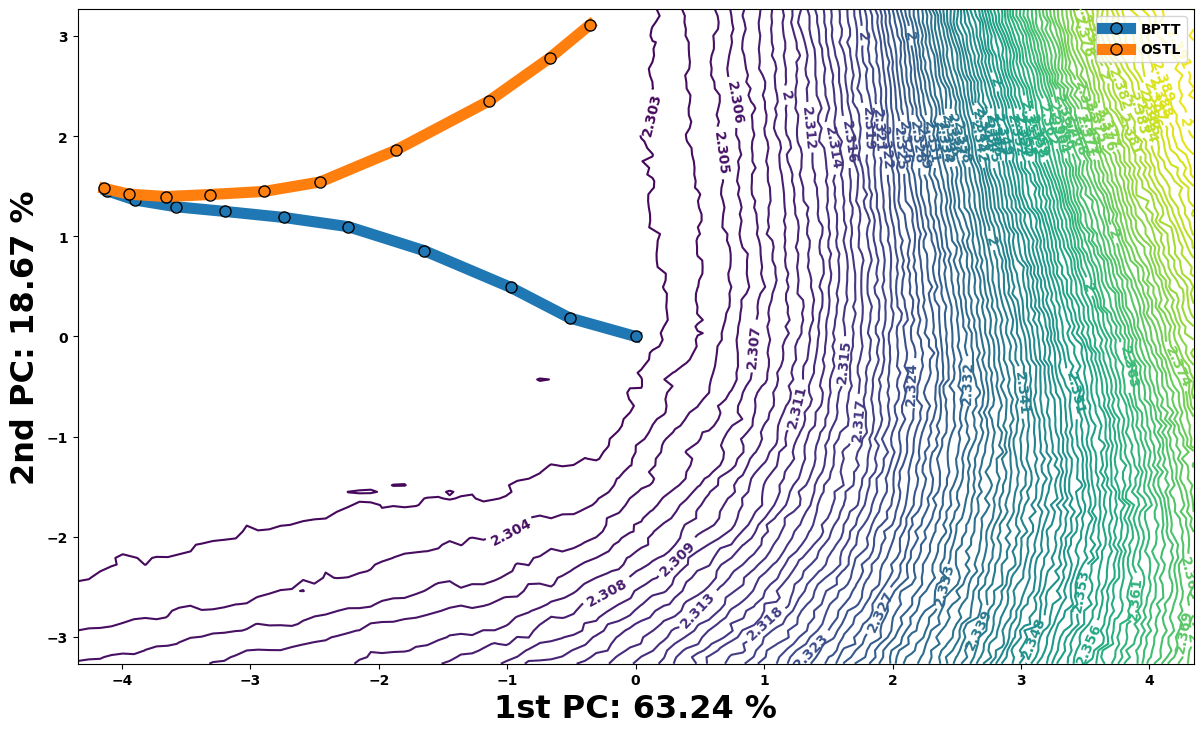

In [33]:
sl.gen_loss_landscape(get_loss,load_params,10,2)
plt.legend(['BPTT','OSTL'])
